<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/rating_models_unseen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
# Import Libaries
import os
import sys
import json
import pandas as pd
import numpy as np
import importlib
import pandas_gbq

from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata

# Install scikit learn
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report


In [73]:
# Install Trueskill library
!pip install trueskill
from trueskill import Rating, rate_1vs1

In [74]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current working directory:", current_directory)

# List the contents of the directory
contents = os.listdir(current_directory)

# Print the contents
print("Contents of the directory:", contents)

# Import user defined python functions. Used importlib as having stability issues with simple import and not picking up the files

spec = importlib.util.spec_from_file_location("create_model_results", "/content/drive/MyDrive/birkbeck_msc-project/python_files/create_model_results.py")
create_model_results = importlib.util.module_from_spec(spec)
spec.loader.exec_module(create_model_results)

#from create_model_results import create_model_results_df


spec = importlib.util.spec_from_file_location("ratings_functions", "/content/drive/MyDrive/birkbeck_msc-project/python_files/ratings_functions.py")
ratings_functions = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ratings_functions)

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/birkbeck_msc-project/python_files
Contents of the directory: ['__pycache__', 'ratings_functions.py', 'all_ranks.xlsx', 'all_ranking_results.xlsx', 'best_ml_model_confusion_matrix_results.xlsx', 'model_evaluation_functions.py', 'create_model_results.py']


In [75]:
#with open('create_model_results.py', 'r') as file:
 #   print(file.read())
import inspect
print(inspect.getsource(create_model_results.create_model_results_df))

def create_model_results_df (all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name, test_flag):

    from sklearn.metrics import log_loss
    print(f"Model name received: '{model_name}'")

    report_dict = classification_report(all_y_test_true, all_y_test_pred, output_dict=True)
    cm = confusion_matrix(all_y_test_true, all_y_test_pred)

    metrics = []
    values = []

    # Add cross-validation Train Accuracy Mean
    avg_train_accuracy = np.mean(train_accuracies)
    metrics.append(f'{test_flag} Train Accuracy Mean')
    values.append(avg_train_accuracy)

    # Add Cross Validation Train Accuracy Standard Deviation
    std_train_accuracy = np.std(train_accuracies)
    metrics.append(f'{test_flag} Standard Deviation')
    values.append(std_train_accuracy)

    # Add Test Accuracy Mean
    avg_test_accuracy = np.mean(test_accuracies)
    metrics.

In [76]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [77]:
def load_predictions_and_ratings_to_bigquery(client, predictions_df, fold_ratings_df, ratings_model):

  # Load predictions to Big Query
  # Specify the target table
  load_dataset_name = 'analysis_layer'
  load_table_name = 'ratings_predictions_unseen'
  load_table_ref = f"{load_dataset_name}.{load_table_name}"

  # Delete predicitons method already inserted
  delete_query = f"DELETE FROM `{load_dataset_name}.{load_table_name}` WHERE ratings_model = '{ratings_model}'"
  delete_job = client.query(delete_query)
  delete_result = delete_job.result()
  predictions_total_rows_deleted = delete_result.num_dml_affected_rows
  print(f"Big Query target predictions table {load_dataset_name}.{load_table_name} rows deleted: {predictions_total_rows_deleted}")

  # Insert predictions for ratings model data to the existing table
  job_config = bigquery.LoadJobConfig(
          write_disposition="WRITE_APPEND")
  load_job = client.load_table_from_dataframe(
          predictions_df, load_table_ref, job_config=job_config)
  # Wait for the job to complete
  load_job.result()
  predictions_num_rows_inserted = load_job.output_rows
  print(f"{predictions_num_rows_inserted} rows appended to predictions table {load_table_ref} successfully.")

  # Load fold ratings to Big Query

  # Specify the target table
  load_dataset_name = 'analysis_layer'
  load_table_name = 'ratings_unseen'
  load_table_ref = f"{load_dataset_name}.{load_table_name}"

  # Delete ratings method already inserted
  delete_query = f"DELETE FROM `{load_dataset_name}.{load_table_name}` WHERE ratings_model = '{ratings_model}'"
  delete_job = client.query(delete_query)
  delete_result = delete_job.result()
  ratings_total_rows_deleted = delete_result.num_dml_affected_rows
  print(f"Big Query target ratings table {load_dataset_name}.{load_table_name} rows deleted: {ratings_total_rows_deleted}")


  # Insert ratings for ratings model data to the existing table
  job_config = bigquery.LoadJobConfig(
          write_disposition="WRITE_APPEND")
  load_job = client.load_table_from_dataframe(
          ratings_df, load_table_ref, job_config=job_config)

  load_job.result()  # Wait for the job to complete

  ratings_num_rows_inserted = load_job.output_rows
  print(f"{ratings_num_rows_inserted} rows appended to ratings table {load_table_ref} successfully.")

  return


In [78]:
def predict_winner_upset (home_team_no, away_team_no, home_team_league_level, away_team_league_level, ranked_ratings):
    home_team_info = next((info for info in ranked_ratings if info[0] == home_team_no), None)
    away_team_info = next((info for info in ranked_ratings if info[0] == away_team_no), None)

    if home_team_info is None or away_team_info is None:
        raise ValueError("Team number not found in ratings list.")

    home_team_rating, home_team_rank = home_team_info[1], home_team_info[2]
    away_team_rating, away_team_rank = away_team_info[1], away_team_info[2]

    # Calculate the basic probability of the higer ranked team winning based proportionally as part of the total rank. Calculation reflects the fact lowest number is higher rank

    home_team_upset_probability = 1 - (home_team_rank / (home_team_rank + away_team_rank))
    away_team_upset_probability = 1 - (away_team_rank / (home_team_rank + away_team_rank))


    # Determine the predicted winner and if it's an upset
    if home_team_rating > away_team_rating:
        predicted_winner = home_team_no
        predicted_upset = 1 if home_team_league_level > away_team_league_level else 0
    else:
        predicted_winner = away_team_no
        predicted_upset = 1 if away_team_league_level > home_team_league_level else 0

    # Probaility of upset based on league level and rank differnce
    if home_team_league_level > away_team_league_level:
       upset_probability = home_team_upset_probability
    else:
       upset_probability = away_team_upset_probability

    return predicted_winner, predicted_upset, home_team_rating, away_team_rating, home_team_rank, away_team_rank, upset_probability

In [91]:
def run_rating_models_single_split (train_data, test_data, ratings_function, ratings_model):
    # Initialize lists to store results
    train_accuracies = []
    train_recalls = []
    test_accuracies = []
    test_recalls = []
    all_y_train_true = []
    all_y_train_pred = []
    all_y_train_pred_proba = []
    all_y_test_true = []
    all_y_test_pred = []
    all_y_test_pred_proba = []
    ratings = []
    test_predictions = []

    # Call rating function
    if ratings_model in ['borda_count', 'average_rank', 'local_kemeny_optimisation']:
        model_ratings = ratings_function(1)  # Use 1 as a placeholder for fold and used when testign in unseen and single split
    else:
        model_ratings = ratings_function(train_data)

    # Add ranks based on the sorted order
    sorted_ratings = sorted(model_ratings, key=lambda x: x[1], reverse=True)
    ranked_ratings = [(team_no, rating, index + 1) for index, (team_no, rating) in enumerate(sorted_ratings)]

    # Append the ratings to the list
    ratings_list = [(ratings_model, 1, team_no, rating) for team_no, rating in model_ratings]
    ratings.extend(ratings_list)

    # Predict upsets for train data
    train_actual_upsets = []
    train_predicted_upsets = []
    train_upset_probabilities = []

    for _, row in train_data.iterrows():
        predicted_winner, predicted_upset, home_team_rating, away_team_rating, home_team_rank, away_team_rank, upset_probability = predict_winner_upset(
            row['home_team_no'], row['away_team_no'],
            row['home_team_league_level'], row['away_team_league_level'],
            ranked_ratings
        )
        actual_upset = row['actual_upset']
        train_actual_upsets.append(actual_upset)
        train_predicted_upsets.append(predicted_upset)
        train_upset_probabilities.append(upset_probability)

    # Calculate train metrics
    train_accuracy = accuracy_score(train_actual_upsets, train_predicted_upsets)
    train_recall = recall_score(train_actual_upsets, train_predicted_upsets)
    train_accuracies.append(train_accuracy)
    train_recalls.append(train_recall)
    all_y_train_true.extend(train_actual_upsets)
    all_y_train_pred.extend(train_predicted_upsets)
    all_y_train_pred_proba.extend(train_upset_probabilities)

    # Predict upsets for test data
    test_actual_upsets = []
    test_predicted_upsets = []
    test_upset_probabilities = []

    for _, row in test_data.iterrows():
        predicted_winner, predicted_upset, home_team_rating, away_team_rating, home_team_rank, away_team_rank, upset_probability = predict_winner_upset(
            row['home_team_no'], row['away_team_no'],
            row['home_team_league_level'], row['away_team_league_level'],
            ranked_ratings
        )
        actual_upset = row['actual_upset']
        test_actual_upsets.append(actual_upset)
        test_predicted_upsets.append(predicted_upset)
        test_upset_probabilities.append(upset_probability)

        test_predictions.append({
            'ratings_model': ratings_model,
            'match_id': row['match_id'],
            'home_team_no': row['home_team_no'],
            'home_team_league_level': row['home_team_league_level'],
            'away_team_no': row['away_team_no'],
            'away_team_league_level': row['away_team_league_level'],
            'home_team_rating': home_team_rating,
            'away_team_rating': away_team_rating,
            'home_team_rank': home_team_rank,
            'away_team_rank': away_team_rank,
            'predicted_winner': predicted_winner,
            'actual_winner': row['actual_winning_team_no'],
            'actual_upset': actual_upset,
            'predicted_upset': predicted_upset,
            'upset_probability': upset_probability,
        })

    # Calculate test metrics
    test_accuracy = accuracy_score(test_actual_upsets, test_predicted_upsets)
    test_recall = recall_score(test_actual_upsets, test_predicted_upsets)
    test_accuracies.append(test_accuracy)
    test_recalls.append(test_recall)
    all_y_test_true.extend(test_actual_upsets)
    all_y_test_pred.extend(test_predicted_upsets)
    all_y_test_pred_proba.extend(test_upset_probabilities)

    print(f"Train Accuracy: {train_accuracy:.3f}, Train Recall: {train_recall:.3f}")
    print(f"Test Accuracy: {test_accuracy:.3f}, Test Recall: {test_recall:.3f}")

    test_predictions_df = pd.DataFrame(test_predictions)

    # Create ratings DataFrame
    ratings_df = pd.DataFrame(ratings, columns=['ratings_model', 'fold_number', 'team_no', 'rating'])
    ratings_df = ratings_df.sort_values(['team_no', 'fold_number'])
    ratings_df['rank'] = ratings_df.groupby('fold_number')['rating'].rank(ascending=False, method='dense').astype(int)

    return ratings_df, test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, ratings_model

In [80]:
# Results & Rank Dataframes
all_ranks_df = pd.DataFrame(columns=['team_no','fold_number'])
display(all_ranks_df)

all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)

,team_no,fold_number


,metric_id,metric


In [81]:
# Train and unseen data

fa_cup_scores_all = """
    SELECT * FROM preparation_layer.view_fa_cup_scores ORDER BY sort_order ASC
"""

fa_cup_scores_all_df = client.query(fa_cup_scores_all).to_dataframe()
display(fa_cup_scores_all_df)


fa_cup_scores__all_train_df = fa_cup_scores_all_df[~fa_cup_scores_all_df['season_year'].isin(['21/22', '22/23'])]
fa_cup_scores_test_all_unseen_df = fa_cup_scores_all_df[fa_cup_scores_all_df['season_year'].isin(['21/22', '22/23'])]

,season_year,match_id,match_date,home_team_no,home_team_name,home_team_league_level,home_team_score,away_team_no,away_team_name,away_team_league_level,away_team_score,actual_winning_team_no,actual_losing_team_no,home_win,away_win,actual_upset,sort_order,match_count
0,08/09,1428623,2009-01-03,27,Preston North End,2,0,1,Liverpool,1,2,1,27,0,1,0,1,1
1,09/10,505337,2010-01-03,1,Chelsea,1,5,34,Watford,2,0,1,34,1,0,0,1,1
2,14/15,1138603,2015-01-04,1,Chelsea,1,3,25,Watford,2,0,1,25,1,0,0,1,1
3,16/17,1345813,2017-01-08,1,Chelsea,1,4,48,Peterborough United,3,1,1,48,1,0,0,1,1
4,20/21,201912,2021-01-09,1,Manchester United,1,1,25,Watford,2,0,1,25,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,22/23,721706,2023-01-07,59,Grimsby Town,4,1,54,Burton Albion,3,0,59,54,1,0,1,54,1
346,09/10,507052,2010-01-02,60,Torquay United,4,0,55,Brighton & Hove Albion,3,1,55,60,0,1,0,55,1
347,16/17,1349585,2017-01-07,55,Wycombe Wanderers,4,2,64,Stourbridge,6,1,55,64,1,0,0,55,1
348,09/10,476038,2010-01-19,57,Notts County,4,2,64,Forest Green Rovers,5,1,57,64,1,0,0,57,1


Train Accuracy: 0.731, Train Recall: 0.000
Test Accuracy: 0.644, Test Recall: 0.000


,ratings_model,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,home_team_rank,away_team_rank,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,basic_position,1625432,53,4,1,1,0.018868,1.000000,53,1,1,1,0,0,0.018519
2,basic_position,6604,50,3,1,1,0.020000,1.000000,50,1,1,1,0,0,0.019608
3,basic_position,1620324,2,1,50,3,0.500000,0.020000,2,50,2,2,0,0,0.038462
4,basic_position,1621206,3,1,61,5,0.333333,0.016393,3,61,3,3,0,0,0.046875
5,basic_position,6752,45,3,4,1,0.022222,0.250000,45,4,4,45,1,0,0.081633
6,basic_position,1620377,32,2,5,1,0.031250,0.200000,32,5,5,32,1,0,0.135135
7,basic_position,6905,5,1,49,3,0.200000,0.020408,5,49,5,5,0,0,0.092593
8,basic_position,1620344,6,1,52,3,0.166667,0.019231,6,52,6,6,0,0,0.103448
9,basic_position,721619,25,2,6,1,0.040000,0.166667,25,6,6,6,0,0,0.193548
10,basic_position,1620367,8,1,29,2,0.125000,0.034483,8,29,8,8,0,0,0.216216


,ratings_model,fold_number,team_no,rating,rank
1,basic_position,1,1,1.000000,1
2,basic_position,1,2,0.500000,2
3,basic_position,1,3,0.333333,3
4,basic_position,1,4,0.250000,4
5,basic_position,1,5,0.200000,5
...,...,...,...,...,...
60,basic_position,1,60,0.016667,60
61,basic_position,1,61,0.016393,61
62,basic_position,1,62,0.016129,62
63,basic_position,1,63,0.015873,63


Big Query target predictions table analysis_layer.ratings_predictions_unseen rows deleted: 45
45 rows appended to predictions table analysis_layer.ratings_predictions_unseen successfully.
Big Query target ratings table analysis_layer.ratings_unseen rows deleted: 64
64 rows appended to ratings table analysis_layer.ratings_unseen successfully.


,team_no,fold_number,basic_position
0,1,1,1
1,2,1,2
2,3,1,3
3,4,1,4
4,5,1,5
...,...,...,...
59,60,1,60
60,61,1,61
61,62,1,62
62,63,1,63


Model name received: 'basic_position'
0.5373193183111064
0.6128463886162409


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,metric_id,metric,basic_position
0,1,Unseen Train Accuracy Mean,0.731
1,2,Unseen Standard Deviation,0.000
2,3,Unseen Accuracy Mean,0.644
3,4,Unseen Accuracy Standard Deviation,0.000
4,5,Unseen Train Recall Mean,0.000
5,6,Unseen rain Recall Standard Deviation,0.000
6,7,Unseen Test Recall Mean,0.000
7,8,Unseen Test Recall Standard Deviation,0.000
8,9,Unseen Train Log Loss,0.537
9,10,Unseen Test Log Loss,0.613


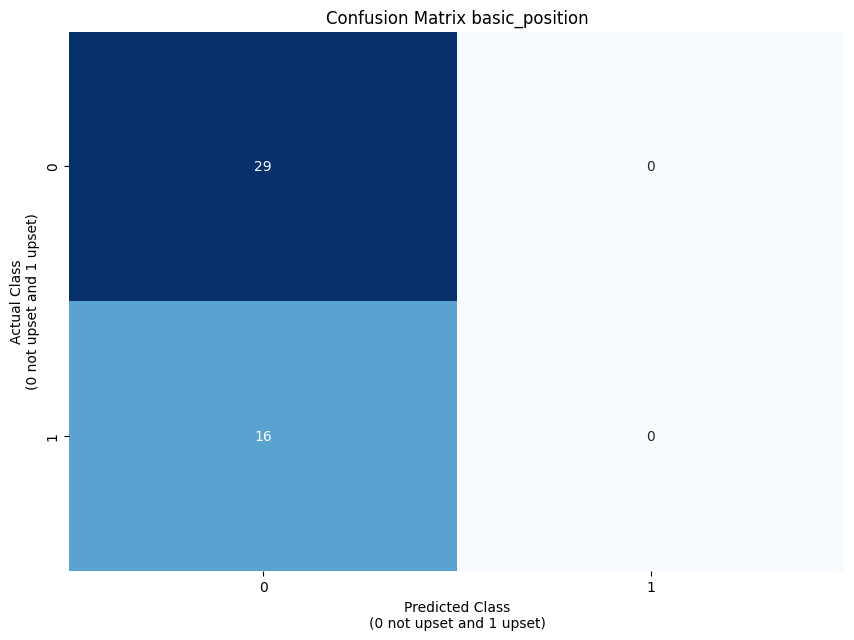

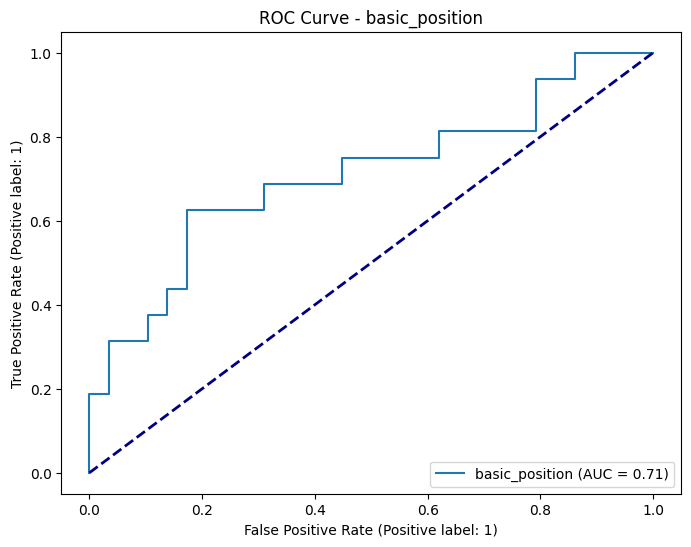

In [82]:
# Basic Position Ratings
ratings_model = 'basic_position'
ratings_function = ratings_functions.basic_position_ratings
test_flag = 'Unseen'

# Call ratings function and train test split
(ratings_df, test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 train_accuracies, train_recalls, test_accuracies, test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) =  run_rating_models_single_split (fa_cup_scores__all_train_df, fa_cup_scores_test_all_unseen_df, ratings_function, ratings_model)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df (all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)



305
Train Accuracy: 0.784, Train Recall: 0.378
Test Accuracy: 0.667, Test Recall: 0.375


,ratings_model,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,home_team_rank,away_team_rank,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,massey,1625432,53,4,1,1,-1.373229,3.551599,58,1,1,1,0,0,0.016949
2,massey,6604,50,3,1,1,-0.593350,3.551599,43,1,1,1,0,0,0.022727
3,massey,1620324,2,1,50,3,2.227097,-0.593350,3,43,2,2,0,0,0.065217
4,massey,1621206,3,1,61,5,2.566013,-0.991184,2,51,3,3,0,0,0.037736
5,massey,6752,45,3,4,1,-0.302274,2.223983,36,4,4,45,1,0,0.100000
6,massey,1620377,32,2,5,1,0.437952,1.735380,21,6,5,32,1,0,0.222222
7,massey,6905,5,1,49,3,1.735380,0.258510,6,26,5,5,0,0,0.187500
8,massey,1620344,6,1,52,3,1.063906,-1.046202,11,53,6,6,0,0,0.171875
9,massey,721619,25,2,6,1,1.902131,1.063906,5,11,25,6,0,1,0.687500
10,massey,1620367,8,1,29,2,0.516821,-0.932601,19,50,8,8,0,0,0.275362


,ratings_model,fold_number,team_no,rating,rank
1,massey,1,1,3.551599,1
2,massey,1,2,2.227097,3
3,massey,1,3,2.566013,2
4,massey,1,4,2.223983,4
5,massey,1,5,1.735380,6
...,...,...,...,...,...
60,massey,1,60,-2.065251,64
61,massey,1,61,-0.991184,51
62,massey,1,62,-1.125761,55
63,massey,1,63,-1.696635,62


Big Query target predictions table analysis_layer.ratings_predictions_unseen rows deleted: 0
45 rows appended to predictions table analysis_layer.ratings_predictions_unseen successfully.
Big Query target ratings table analysis_layer.ratings_unseen rows deleted: 0
64 rows appended to ratings table analysis_layer.ratings_unseen successfully.


,team_no,fold_number,basic_position,massey
0,1,1,1,1
1,2,1,2,3
2,3,1,3,2
3,4,1,4,4
4,5,1,5,6
...,...,...,...,...
59,60,1,60,64
60,61,1,61,51
61,62,1,62,55
62,63,1,63,62


Model name received: 'massey'
0.47636586543397536
0.7016595135541868


,metric_id,metric,basic_position,massey
0,1,Unseen Train Accuracy Mean,0.731,0.784
1,2,Unseen Standard Deviation,0.000,0.000
2,3,Unseen Accuracy Mean,0.644,0.667
3,4,Unseen Accuracy Standard Deviation,0.000,0.000
4,5,Unseen Train Recall Mean,0.000,0.378
5,6,Unseen rain Recall Standard Deviation,0.000,0.000
6,7,Unseen Test Recall Mean,0.000,0.375
7,8,Unseen Test Recall Standard Deviation,0.000,0.000
8,9,Unseen Train Log Loss,0.537,0.476
9,10,Unseen Test Log Loss,0.613,0.702


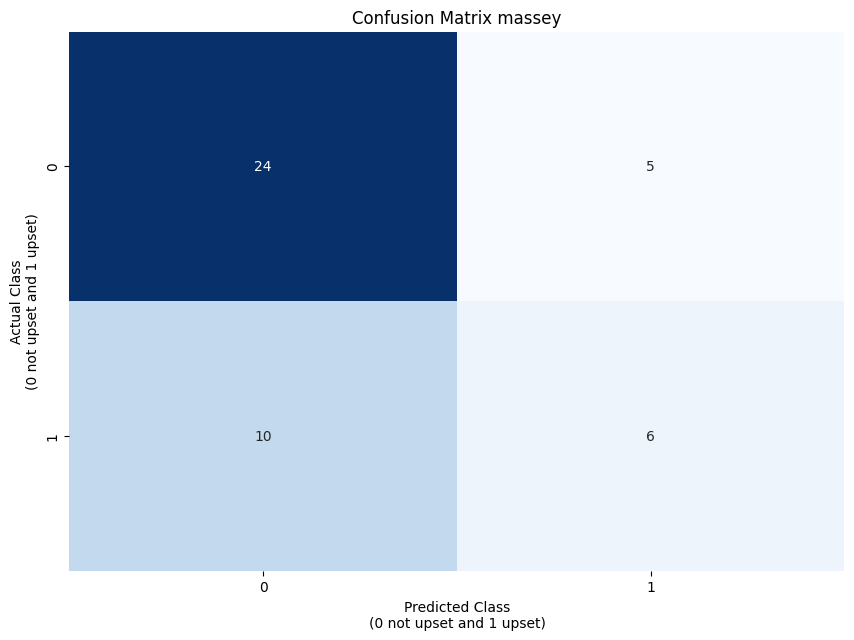

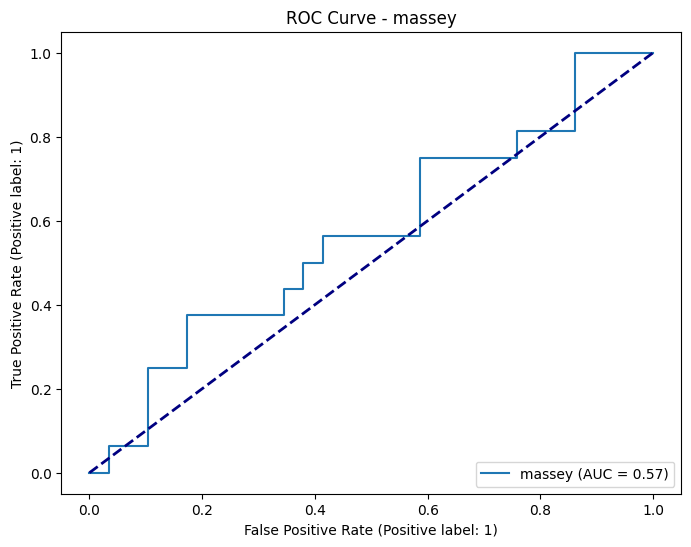

In [83]:
# Massey Ratings
ratings_model = 'massey'
ratings_function = ratings_functions.massey_ratings
test_flag = 'Unseen'

# Call ratings function and train test split
(ratings_df, test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 train_accuracies, train_recalls, test_accuracies, test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) =  run_rating_models_single_split (fa_cup_scores__all_train_df, fa_cup_scores_test_all_unseen_df, ratings_function, ratings_model)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df (all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

305
Train Accuracy: 0.807, Train Recall: 0.476
Test Accuracy: 0.578, Test Recall: 0.312


,ratings_model,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,home_team_rank,away_team_rank,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,colley,1625432,53,4,1,1,0.281657,0.907022,58,1,1,1,0,0,0.016949
2,colley,6604,50,3,1,1,0.455871,0.907022,34,1,1,1,0,0,0.028571
3,colley,1620324,2,1,50,3,0.781259,0.455871,7,34,2,2,0,0,0.170732
4,colley,1621206,3,1,61,5,0.869622,0.290729,2,57,3,3,0,0,0.033898
5,colley,6752,45,3,4,1,0.515047,0.851135,30,3,4,45,1,0,0.090909
6,colley,1620377,32,2,5,1,0.517990,0.813001,29,5,5,32,1,0,0.147059
7,colley,6905,5,1,49,3,0.813001,0.592551,5,22,5,5,0,0,0.185185
8,colley,1620344,6,1,52,3,0.657048,0.296425,14,54,6,6,0,0,0.205882
9,colley,721619,25,2,6,1,0.730330,0.657048,10,14,25,6,0,1,0.583333
10,colley,1620367,8,1,29,2,0.696605,0.312988,12,52,8,8,0,0,0.187500


,ratings_model,fold_number,team_no,rating,rank
1,colley,1,1,0.907022,1
2,colley,1,2,0.781259,7
3,colley,1,3,0.869622,2
4,colley,1,4,0.851135,3
5,colley,1,5,0.813001,5
...,...,...,...,...,...
60,colley,1,60,0.293820,55
61,colley,1,61,0.290729,57
62,colley,1,62,0.277441,59
63,colley,1,63,0.342910,46


Big Query target predictions table analysis_layer.ratings_predictions_unseen rows deleted: 0
45 rows appended to predictions table analysis_layer.ratings_predictions_unseen successfully.
Big Query target ratings table analysis_layer.ratings_unseen rows deleted: 0
64 rows appended to ratings table analysis_layer.ratings_unseen successfully.


,team_no,fold_number,basic_position,massey,colley
0,1,1,1,1,1
1,2,1,2,3,7
2,3,1,3,2,2
3,4,1,4,4,3
4,5,1,5,6,5
...,...,...,...,...,...
59,60,1,60,64,55
60,61,1,61,51,57
61,62,1,62,55,59
62,63,1,63,62,46


Model name received: 'colley'
0.4523424539654095
0.6991191515454478


,metric_id,metric,basic_position,massey,colley
0,1,Unseen Train Accuracy Mean,0.731,0.784,0.807
1,2,Unseen Standard Deviation,0.000,0.000,0.000
2,3,Unseen Accuracy Mean,0.644,0.667,0.578
3,4,Unseen Accuracy Standard Deviation,0.000,0.000,0.000
4,5,Unseen Train Recall Mean,0.000,0.378,0.476
5,6,Unseen rain Recall Standard Deviation,0.000,0.000,0.000
6,7,Unseen Test Recall Mean,0.000,0.375,0.312
7,8,Unseen Test Recall Standard Deviation,0.000,0.000,0.000
8,9,Unseen Train Log Loss,0.537,0.476,0.452
9,10,Unseen Test Log Loss,0.613,0.702,0.699


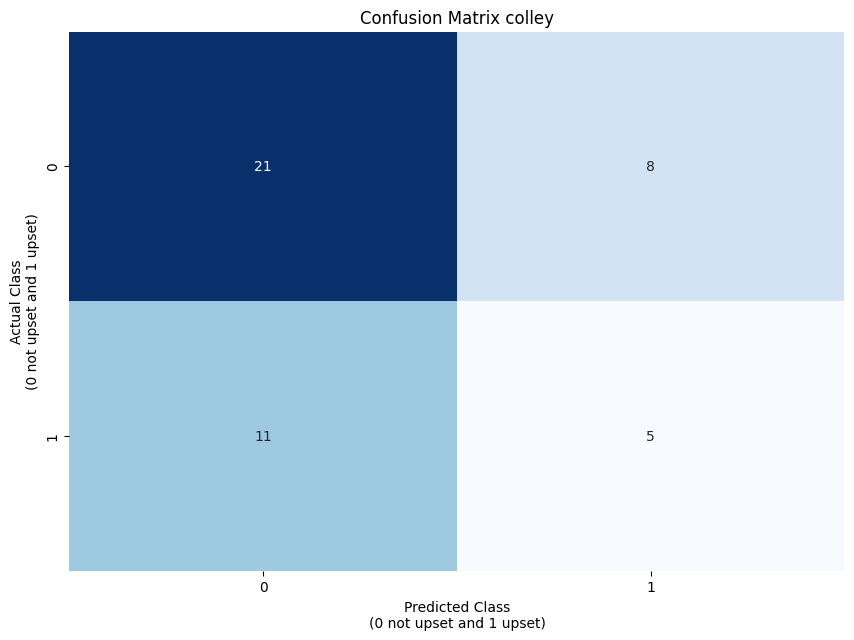

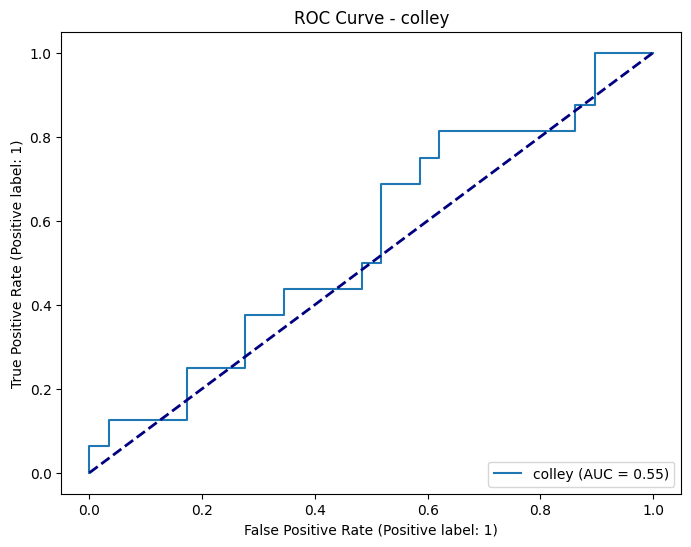

In [84]:
# Colley Ratings
ratings_model = 'colley'
ratings_function = ratings_functions.colley_ratings
test_flag = 'Unseen'

# Call ratings function and train test split
(ratings_df, test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 train_accuracies, train_recalls, test_accuracies, test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) =  run_rating_models_single_split (fa_cup_scores__all_train_df, fa_cup_scores_test_all_unseen_df, ratings_function, ratings_model)

# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df (all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

Train Accuracy: 0.777, Train Recall: 0.378
Test Accuracy: 0.578, Test Recall: 0.250


,ratings_model,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,home_team_rank,away_team_rank,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,keener,1625432,53,4,1,1,0.114682,0.131072,64,14,1,1,0,0,0.179487
2,keener,6604,50,3,1,1,0.122613,0.131072,39,14,1,1,0,0,0.264151
3,keener,1620324,2,1,50,3,0.136021,0.122613,4,39,2,2,0,0,0.093023
4,keener,1621206,3,1,61,5,0.135465,0.117221,5,59,3,3,0,0,0.078125
5,keener,6752,45,3,4,1,0.124071,0.137278,31,2,4,45,1,0,0.060606
6,keener,1620377,32,2,5,1,0.122606,0.138813,40,1,5,32,1,0,0.024390
7,keener,6905,5,1,49,3,0.138813,0.123081,1,35,5,5,0,0,0.027778
8,keener,1620344,6,1,52,3,0.132024,0.120459,9,46,6,6,0,0,0.163636
9,keener,721619,25,2,6,1,0.131969,0.132024,10,9,6,6,0,0,0.473684
10,keener,1620367,8,1,29,2,0.133666,0.119583,7,52,8,8,0,0,0.118644


,ratings_model,fold_number,team_no,rating,rank
1,keener,1,1,0.131072,14
2,keener,1,2,0.136021,4
3,keener,1,3,0.135465,5
4,keener,1,4,0.137278,2
5,keener,1,5,0.138813,1
...,...,...,...,...,...
60,keener,1,60,0.119768,51
61,keener,1,61,0.117221,59
62,keener,1,62,0.116000,62
63,keener,1,63,0.120081,47


Big Query target predictions table analysis_layer.ratings_predictions_unseen rows deleted: 0
45 rows appended to predictions table analysis_layer.ratings_predictions_unseen successfully.
Big Query target ratings table analysis_layer.ratings_unseen rows deleted: 0
64 rows appended to ratings table analysis_layer.ratings_unseen successfully.


,team_no,fold_number,basic_position,massey,colley,keener
0,1,1,1,1,1,14
1,2,1,2,3,7,4
2,3,1,3,2,2,5
3,4,1,4,4,3,2
4,5,1,5,6,5,1
...,...,...,...,...,...,...
59,60,1,60,64,55,51
60,61,1,61,51,57,59
61,62,1,62,55,59,62
62,63,1,63,62,46,47


Model name received: 'keener'
0.4735049771362672
0.725208382415831


,metric_id,metric,basic_position,massey,colley,keener
0,1,Unseen Train Accuracy Mean,0.731,0.784,0.807,0.777
1,2,Unseen Standard Deviation,0.000,0.000,0.000,0.000
2,3,Unseen Accuracy Mean,0.644,0.667,0.578,0.578
3,4,Unseen Accuracy Standard Deviation,0.000,0.000,0.000,0.000
4,5,Unseen Train Recall Mean,0.000,0.378,0.476,0.378
5,6,Unseen rain Recall Standard Deviation,0.000,0.000,0.000,0.000
6,7,Unseen Test Recall Mean,0.000,0.375,0.312,0.250
7,8,Unseen Test Recall Standard Deviation,0.000,0.000,0.000,0.000
8,9,Unseen Train Log Loss,0.537,0.476,0.452,0.474
9,10,Unseen Test Log Loss,0.613,0.702,0.699,0.725


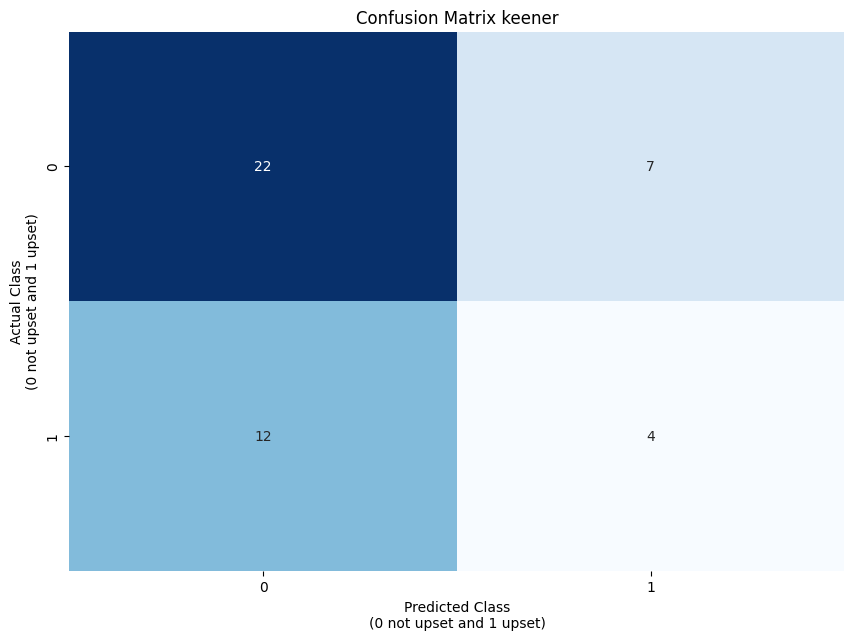

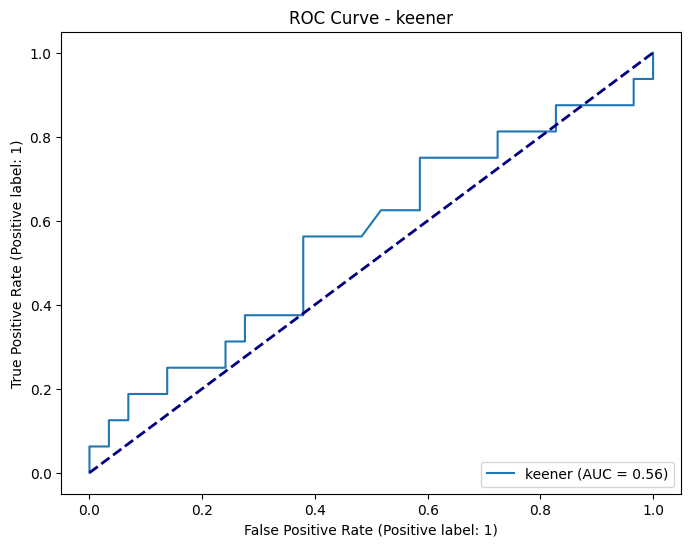

In [85]:
# Keener Ratings
ratings_model = 'keener'
ratings_function = ratings_functions.keener_ratings
test_flag = 'Unseen'

# Call ratings function and train test split
(ratings_df, test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 train_accuracies, train_recalls, test_accuracies, test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) =  run_rating_models_single_split (fa_cup_scores__all_train_df, fa_cup_scores_test_all_unseen_df, ratings_function, ratings_model)

# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df (all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

Train Accuracy: 0.803, Train Recall: 0.500
Test Accuracy: 0.511, Test Recall: 0.312


,ratings_model,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,home_team_rank,away_team_rank,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,trueskill,1625432,53,4,1,1,18.764733,39.481729,57,1,1,1,0,0,0.017241
2,trueskill,6604,50,3,1,1,23.483014,39.481729,34,1,1,1,0,0,0.028571
3,trueskill,1620324,2,1,50,3,34.247977,23.483014,6,34,2,2,0,0,0.150000
4,trueskill,1621206,3,1,61,5,36.896758,17.527863,4,61,3,3,0,0,0.061538
5,trueskill,6752,45,3,4,1,24.506290,37.791957,29,2,4,45,1,0,0.064516
6,trueskill,1620377,32,2,5,1,25.139710,37.451454,28,3,5,32,1,0,0.096774
7,trueskill,6905,5,1,49,3,37.451454,29.723746,3,14,5,5,0,0,0.176471
8,trueskill,1620344,6,1,52,3,29.122200,20.708120,15,46,6,6,0,0,0.245902
9,trueskill,721619,25,2,6,1,32.865547,29.122200,8,15,25,6,0,1,0.652174
10,trueskill,1620367,8,1,29,2,30.171502,20.726706,12,45,8,8,0,0,0.210526


,ratings_model,fold_number,team_no,rating,rank
1,trueskill,1,1,39.481729,1
2,trueskill,1,2,34.247977,6
3,trueskill,1,3,36.896758,4
4,trueskill,1,4,37.791957,2
5,trueskill,1,5,37.451454,3
...,...,...,...,...,...
60,trueskill,1,60,20.306053,51
61,trueskill,1,61,17.527863,61
62,trueskill,1,62,18.197100,60
63,trueskill,1,63,20.455993,50


Big Query target predictions table analysis_layer.ratings_predictions_unseen rows deleted: 0
45 rows appended to predictions table analysis_layer.ratings_predictions_unseen successfully.
Big Query target ratings table analysis_layer.ratings_unseen rows deleted: 0
64 rows appended to ratings table analysis_layer.ratings_unseen successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill
0,1,1,1,1,1,14,1
1,2,1,2,3,7,4,6
2,3,1,3,2,2,5,4
3,4,1,4,4,3,2,2
4,5,1,5,6,5,1,3
...,...,...,...,...,...,...,...
59,60,1,60,64,55,51,51
60,61,1,61,51,57,59,61
61,62,1,62,55,59,62,60
62,63,1,63,62,46,47,50


Model name received: 'trueskill'
0.4576150677168203
0.7405203138331804


,metric_id,metric,basic_position,massey,colley,keener,trueskill
0,1,Unseen Train Accuracy Mean,0.731,0.784,0.807,0.777,0.803
1,2,Unseen Standard Deviation,0.000,0.000,0.000,0.000,0.000
2,3,Unseen Accuracy Mean,0.644,0.667,0.578,0.578,0.511
3,4,Unseen Accuracy Standard Deviation,0.000,0.000,0.000,0.000,0.000
4,5,Unseen Train Recall Mean,0.000,0.378,0.476,0.378,0.500
5,6,Unseen rain Recall Standard Deviation,0.000,0.000,0.000,0.000,0.000
6,7,Unseen Test Recall Mean,0.000,0.375,0.312,0.250,0.312
7,8,Unseen Test Recall Standard Deviation,0.000,0.000,0.000,0.000,0.000
8,9,Unseen Train Log Loss,0.537,0.476,0.452,0.474,0.458
9,10,Unseen Test Log Loss,0.613,0.702,0.699,0.725,0.741


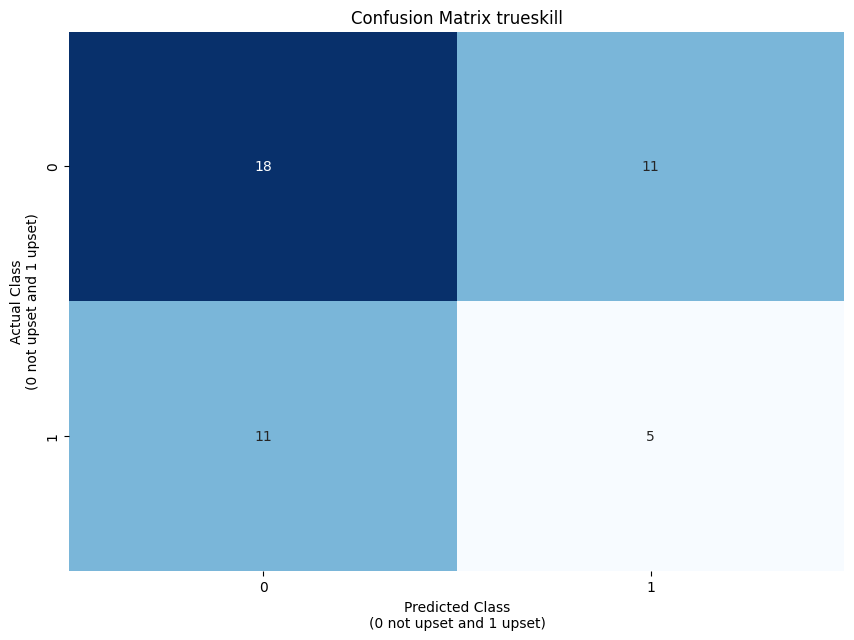

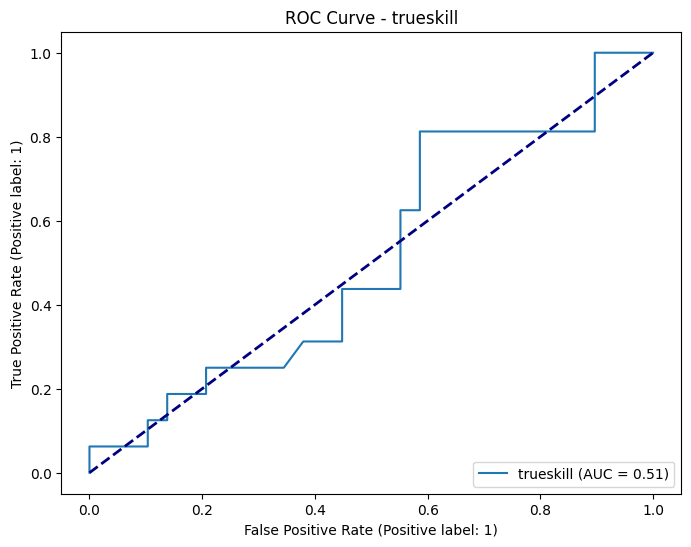

In [86]:
# Trueskill Ratings
ratings_model = 'trueskill'
ratings_function = ratings_functions.trueskill_ratings
test_flag = 'Unseen'

# Call ratings function and train test split
(ratings_df, test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 train_accuracies, train_recalls, test_accuracies, test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) =  run_rating_models_single_split (fa_cup_scores__all_train_df, fa_cup_scores_test_all_unseen_df, ratings_function, ratings_model)

# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df (all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)


In [87]:
# Load all ranks df to Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks_unseen'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

# Load confusion matrix df to Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_confusion_matrix_results_unseen'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_results_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')



100%|██████████| 1/1 [00:00<00:00, 8240.28it/s]


In [93]:
# Rank Aggregation functions called after ratings function have run and results inserted into Big Query

def borda_count_aggregation (fold_counter):

    from google.cloud import bigquery

    # Authenticate using the loaded key
    credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    fold_number = fold_counter
    all_ranks = """
              select * from analysis_layer.ratings_model_ranks_unseen
              """

    all_ranks_df = client.query(all_ranks).to_dataframe()
    all_ranks_df_fold = all_ranks_df[all_ranks_df['fold_number'] == fold_number].sort_values('team_no', ascending=True)
    all_ranks_df_fold['rank_total'] = all_ranks_df_fold[['basic_position','massey','colley','keener','trueskill']].sum(axis=1)
    all_ranks_df_fold['overall_rank'] = all_ranks_df_fold['rank_total'].rank(method='first', ascending=True).astype(int)
    all_ranks_df_fold['rating'] = 1 / all_ranks_df_fold['overall_rank']


    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(all_ranks_df_fold['team_no'], all_ranks_df_fold['rating']))

    return ratings

def average_rank_aggregation (fold_counter):

    from google.cloud import bigquery

    # Authenticate using the loaded key
    credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    fold_number = fold_counter
    all_ranks = """
              select * from analysis_layer.ratings_model_ranks_unseen
              """

    all_ranks_df = client.query(all_ranks).to_dataframe()
    all_ranks_df_fold = all_ranks_df[all_ranks_df['fold_number'] == fold_number].sort_values('team_no', ascending=True)
    all_ranks_df_fold['rank_average'] = all_ranks_df_fold[['basic_position','massey','colley','keener','trueskill']].mean(axis=1)
    all_ranks_df_fold['overall_rank'] = all_ranks_df_fold['rank_average'].rank(method='first', ascending=True).astype(int)
    all_ranks_df_fold['rating'] = 1 / all_ranks_df_fold['overall_rank']
    display(all_ranks_df_fold)


    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(all_ranks_df_fold['team_no'], all_ranks_df_fold['rating']))

    return ratings


Train Accuracy: 0.803, Train Recall: 0.354
Test Accuracy: 0.644, Test Recall: 0.250


,ratings_model,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,home_team_rank,away_team_rank,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,borda_count,1625432,53,4,1,1,0.016393,0.333333,61,3,1,1,0,0,0.046875
2,borda_count,6604,50,3,1,1,0.024390,0.333333,41,3,1,1,0,0,0.068182
3,borda_count,1620324,2,1,50,3,0.200000,0.024390,5,41,2,2,0,0,0.108696
4,borda_count,1621206,3,1,61,5,0.500000,0.016667,2,60,3,3,0,0,0.032258
5,borda_count,6752,45,3,4,1,0.030303,1.000000,33,1,4,45,1,0,0.029412
6,borda_count,1620377,32,2,5,1,0.035714,0.250000,28,4,5,32,1,0,0.125000
7,borda_count,6905,5,1,49,3,0.250000,0.037037,4,27,5,5,0,0,0.129032
8,borda_count,1620344,6,1,52,3,0.111111,0.019608,9,51,6,6,0,0,0.150000
9,borda_count,721619,25,2,6,1,0.090909,0.111111,11,9,6,6,0,0,0.450000
10,borda_count,1620367,8,1,29,2,0.100000,0.020408,10,49,8,8,0,0,0.169492


,ratings_model,fold_number,team_no,rating,rank
1,borda_count,1,1,0.333333,3
2,borda_count,1,2,0.200000,5
3,borda_count,1,3,0.500000,2
4,borda_count,1,4,1.000000,1
5,borda_count,1,5,0.250000,4
...,...,...,...,...,...
60,borda_count,1,60,0.017544,57
61,borda_count,1,61,0.016667,60
62,borda_count,1,62,0.015873,63
63,borda_count,1,63,0.017857,56


Big Query target predictions table analysis_layer.ratings_predictions_unseen rows deleted: 0
45 rows appended to predictions table analysis_layer.ratings_predictions_unseen successfully.
Big Query target ratings table analysis_layer.ratings_unseen rows deleted: 0
64 rows appended to ratings table analysis_layer.ratings_unseen successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,borda_count
0,1,1,1,1,1,14,1,3
1,2,1,2,3,7,4,6,5
2,3,1,3,2,2,5,4,2
3,4,1,4,4,3,2,2,1
4,5,1,5,6,5,1,3,4
...,...,...,...,...,...,...,...,...
59,60,1,60,64,55,51,51,57
60,61,1,61,51,57,59,61,60
61,62,1,62,55,59,62,60,63
62,63,1,63,62,46,47,50,56


Model name received: 'borda_count'
0.4600581634986325
0.6944423255473098


,metric_id,metric,basic_position,massey,colley,keener,trueskill,borda_count
0,1,Unseen Train Accuracy Mean,0.731,0.784,0.807,0.777,0.803,0.803
1,2,Unseen Standard Deviation,0.000,0.000,0.000,0.000,0.000,0.000
2,3,Unseen Accuracy Mean,0.644,0.667,0.578,0.578,0.511,0.644
3,4,Unseen Accuracy Standard Deviation,0.000,0.000,0.000,0.000,0.000,0.000
4,5,Unseen Train Recall Mean,0.000,0.378,0.476,0.378,0.500,0.354
5,6,Unseen rain Recall Standard Deviation,0.000,0.000,0.000,0.000,0.000,0.000
6,7,Unseen Test Recall Mean,0.000,0.375,0.312,0.250,0.312,0.250
7,8,Unseen Test Recall Standard Deviation,0.000,0.000,0.000,0.000,0.000,0.000
8,9,Unseen Train Log Loss,0.537,0.476,0.452,0.474,0.458,0.460
9,10,Unseen Test Log Loss,0.613,0.702,0.699,0.725,0.741,0.694


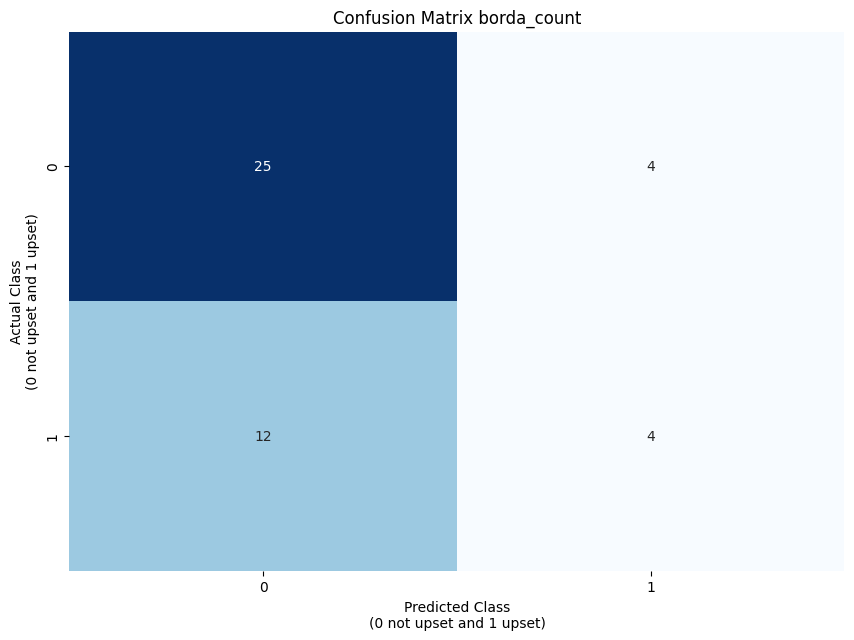

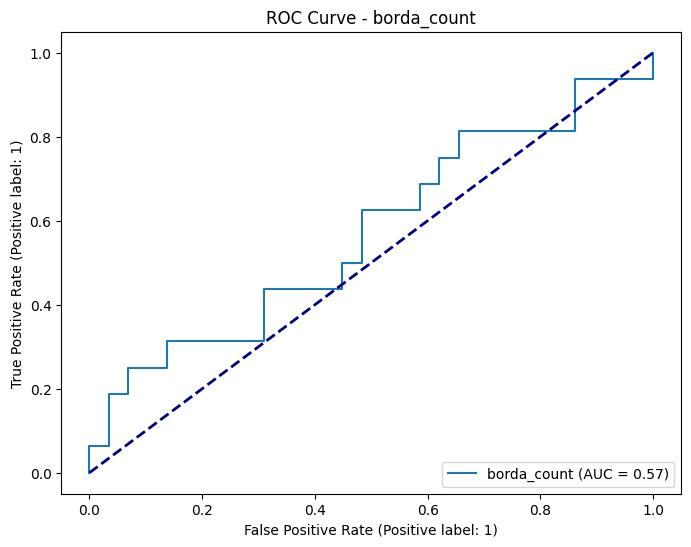

In [90]:
# Borda Count Aggregation
ratings_model = 'borda_count'
ratings_function = borda_count_aggregation
test_flag = 'Unseen'

# Call ratings function and train test split
(ratings_df, test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 train_accuracies, train_recalls, test_accuracies, test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) =  run_rating_models_single_split (fa_cup_scores__all_train_df, fa_cup_scores_test_all_unseen_df, ratings_function, ratings_model)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df (all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [92]:
# Average Rank Aggregation
ratings_model = 'average_rank'
ratings_function = average_rank_aggregation
test_flag = 'Unseen'

# Call ratings function and train test split
(ratings_df, test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 train_accuracies, train_recalls, test_accuracies, test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) =  run_rating_models_single_split (fa_cup_scores__all_train_df, fa_cup_scores_test_all_unseen_df, ratings_function, ratings_model)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df (all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

NotFound: 404 Not found: Table birkbeck-msc-project-422917:analysis_layer.ratings_model_unseen_ranks was not found in location europe-west2; reason: notFound, message: Not found: Table birkbeck-msc-project-422917:analysis_layer.ratings_model_unseen_ranks was not found in location europe-west2

Location: europe-west2
Job ID: fddc09b2-2bf6-4593-87c0-738cf0085514


In [ ]:
# Load updated all ranks df to Big Query so Borda Count can be subsequently queried in local kemeny optimisation
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

In [ ]:
# Local Kemeny Optimisation

def local_kemeny_optimisation (fold_number, max_iterations=10):

    def kendall_tau_distance(ranking1, ranking2):
        distance = 0
        for i in range(len(ranking1)):
            for j in range(i + 1, len(ranking1)):
                if (ranking1[i] < ranking1[j]) != (ranking2[i] < ranking2[j]):
                    distance += 1
        return distance

    def total_kendall_tau_distance(candidate, rankings):
        return sum(kendall_tau_distance(candidate, ranking) for ranking in rankings.values())

    def local_kemeny_optimisation(rankings, initial_ranking, max_iterations):
        n_items = len(initial_ranking)

        current_ranking = initial_ranking.copy()
        current_distance = total_kendall_tau_distance(current_ranking, rankings)

        for iteration in range(max_iterations):
            improved = False
            for i in range(n_items - 1):
                new_ranking = current_ranking.copy()
                new_ranking[i], new_ranking[i+1] = new_ranking[i+1], new_ranking[i]
                new_distance = total_kendall_tau_distance(new_ranking, rankings)

                if new_distance < current_distance:
                    current_ranking = new_ranking
                    current_distance = new_distance
                    improved = True
                    print(f"Iteration {iteration + 1}: Improved distance to {current_distance}")
                    break

            if not improved:
                print(f"Stopped after {iteration + 1} iterations: No improvement")
                break

        if iteration == max_iterations - 1:
            print(f"Stopped after reaching maximum iterations ({max_iterations})")

        return current_ranking

    # Authenticate using the loaded key
    # credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    # Query to get the data
    all_ranks_query = f"""
        SELECT * FROM analysis_layer.ratings_model_unseen_ranks WHERE fold_number = {fold_number}
    """

    all_ranks_df = client.query(all_ranks_query).to_dataframe()

    # Create dictionary of rankings
    rankings = {
        'basic_position': all_ranks_df['basic_position'].tolist(),
        'massey': all_ranks_df['massey'].tolist(),
        'colley': all_ranks_df['colley'].tolist(),
        'keener': all_ranks_df['keener'].tolist(),
        'trueskill': all_ranks_df['trueskill'].tolist()
    }

    # Use Borda count as initial ranking
    borda_count = all_ranks_df['borda_count'].tolist()

    # Perform local Kemeny optimization
    optimized_ranking = local_kemeny_optimisation(rankings, borda_count, max_iterations)
    print("\nTotal Kendall tau distance (Borda Count):", total_kendall_tau_distance(borda_count, rankings))
    print("Total Kendall tau distance (Optimized):", total_kendall_tau_distance(optimized_ranking, rankings))

    # Show which teams changed positions
    team_nos = all_ranks_df['team_no'].tolist()

    # Create a mapping from team number to rank for both rankings
    borda_mapping = {team: rank for rank, team in enumerate(borda_count)}
    optimized_mapping = {team: rank for rank, team in enumerate(optimized_ranking)}

    changes = []
    for team in team_nos:
        borda_rank = borda_mapping.get(team, -1)
        optimized_rank = optimized_mapping.get(team, -1)
        if borda_rank != optimized_rank:
            changes.append((team, borda_rank, optimized_rank))

    print("\nTeams that changed positions (Team, Old Position, New Position):")
    for change in changes:
        print(f"Team {change[0]}: {change[1]} -> {change[2]}")

    # Create a DataFrame with the optimized ranking
    optimized_df = pd.DataFrame({
        'team_no': team_nos,
        'overall_rank': optimized_ranking
    })

    # Calculate the rating based on the optimized ranking
    optimized_df['rating'] = 1 / optimized_df['overall_rank']

    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(optimized_df['team_no'], optimized_df['rating']))

    return ratings


In [ ]:
# Local Kemeny Optimisation

ratings_model = 'local_kemeny_optimisation'
ratings_function = local_kemeny_optimisation
test_flag = 'Unseen'

# Call ratings function and train test split
(ratings_df, test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 train_accuracies, train_recalls, test_accuracies, test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) =  run_rating_models_single_split (fa_cup_scores__all_train_df, fa_cup_scores_test_all_unseen_df, ratings_function, ratings_model)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df (all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Load final ranks including Local Kemeny Optimisation
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks_unseen'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

In [ ]:
# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df.to_excel("all_rating_ranking_unseen_results.xlsx")